# Exercise 4

Authors:
- Tuoxing Liu
- Sima Esmaeili
- Shruti Ghargi

## 1. Constructing the matrix X

alphas.shape=(179,)
y.shape=(49225,)
Np=15


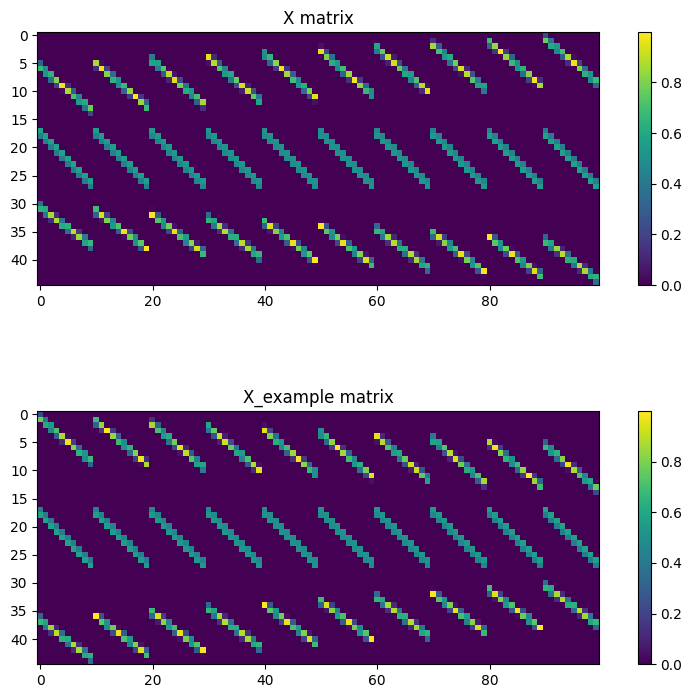

In [3]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import scipy


def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    if Np % 2 == 0:
        Np = Np + 1  # get an odd number for Np
    print(f"Np={Np}")

    D = M * M
    No = len(alphas)
    N = Np * No

    h = 1
    a0 = - (M - 1) / 2
    b0 = - (M - 1) / 2
    s0 = (Np - 1) / 2 # Set the center of response vector as the middle point of the vector
    ja = np.mgrid[0:D] % M
    jb = np.mgrid[0:D] // M
    C = np.stack((a0 + ja * h, b0 + jb * h)) # move the origin of vectors to the center element of matirx X
    # print(f"C.shape={C.shape}")

    i_indices = []
    j_indices = []
    weights = []

    for alpha_idx in range(len(alphas)):
        alpha = alphas[alpha_idx]
        n = np.array([np.cos(np.deg2rad(alpha)), np.sin(np.deg2rad(alpha))]) # the normal vector of angle alpha
        p = np.dot(n.T, C) + s0

        # j_indices is the column index of X
        # j = ja + M * jb, it's the global index in D dimension
        j_indices.extend(ja + M * jb)

        # i_indeces is the row index of X
        # add alpha_idx * Np for different alphas
        # p // 1 to get the integer part of p, which is the index on the response vector
        i_indices.extend((p // 1) + alpha_idx * Np)

        # the weights of X_ij is the decimal part of p
        # need to use 1 - (p % 1) because the smaller the value, the smaller the distance, the larger the impact
        weights.extend(1-(p % 1))

        # We suggest that one pixel in image mu affect two bins in the response vector
        # So now we add the second bin

        j_indices.extend(ja + M * jb)

        # We assume that the pixel only affect the next bin along the index, so (p + 1)
        i_indices.extend(((p + 1) // 1) + alpha_idx * Np)

        # For this bin, the weight is 1-(1-(p % 1)) = p % 1
        weights.extend(p % 1)

    X = coo_matrix((weights, (i_indices, j_indices)),
                   shape=(N, D), dtype=np.float32)
    return X


# data_path = "./hs_tomography/"

y = np.load(os.path.join("y_195.npy"))
alphas = np.load(os.path.join("alphas_195.npy"))

# Example usage
print(f"alphas.shape={alphas.shape}")
print(f"y.shape={y.shape}")
alphas = [-33, 1, 42]
X = construct_X(10, alphas)

# Visualize the matrix with the adjusted color scale
fig, axs = plt.subplots(2,1, figsize=(10,8))
im0 = axs[0].imshow(X.toarray(), cmap='viridis')
axs[0].set_title('X matrix')
fig.colorbar(im0, ax=axs[0])

X_example = np.load('X_example.npy', allow_pickle=True)

im1 = axs[1].imshow(X_example, cmap='viridis')
axs[1].set_title('X_example matrix')
fig.colorbar(im1, ax=axs[1])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5,top = 0.9)

plt.show()

We got a similar but different X. Later we will see it's correct, but rotated 180 degrees.

## 2. Recovering the image

Np=109
X.shape=(9810, 5929), y.shape=(9810,)
[  2.77972667  14.52123702 222.66858281 ...   0.88841959   1.30335149
   0.61690578]


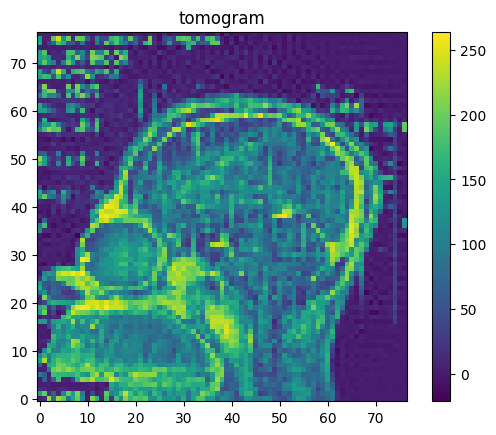

In [5]:
y_77 = np.load("y_77.npy")
alphas_77 = np.load("alphas_77.npy")
M_77 = 77
X_77 = construct_X(M_77, alphas_77,109)
X_77 = scipy.sparse.csc_matrix(X_77)

print(f"X.shape={X_77.shape}, y.shape={y_77.shape}")

beta_77 = scipy.sparse.linalg.lsqr(X_77,y_77, atol =1e-05, btol = 1e-05)[0]
print(beta_77)

plt.imshow(beta_77.reshape(-1,M_77), cmap='viridis', origin='lower')
plt.colorbar()
plt.title('tomogram')
plt.show()

Result from the imported X of M=77.

Np=275
X.shape=(49225, 38025), y.shape=(49225,)
[63.03358901 64.34662705 63.38983305 ... 64.60399762 63.10754693
 61.77244835]


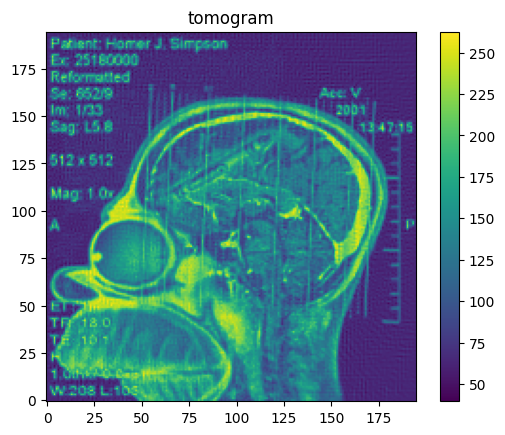

In [6]:
y_195 = np.load(os.path.join("y_195.npy"))
alphas_195 = np.load(os.path.join("alphas_195.npy"))
M_195 = 195
X_195 = construct_X(M_195, alphas_195,275)
X_195 = scipy.sparse.csc_matrix(X_195)

print(f"X.shape={X_195.shape}, y.shape={y_195.shape}")

beta_195 = scipy.sparse.linalg.lsqr(X_195,y_195, atol =1e-05, btol = 1e-05)[0]
print(beta_195)

plt.imshow(beta_195.reshape(-1,M_195), cmap='viridis', origin='lower')
plt.colorbar()
plt.title('tomogram')
plt.show()

Result of self-constructed X_195, with atol=1e-05, btol=1e-05.

X.shape=(49225, 38025), y.shape=(49225,)
[62.98482862 63.95909307 64.68460616 ... 64.6574598  63.06314631
 61.9764222 ]


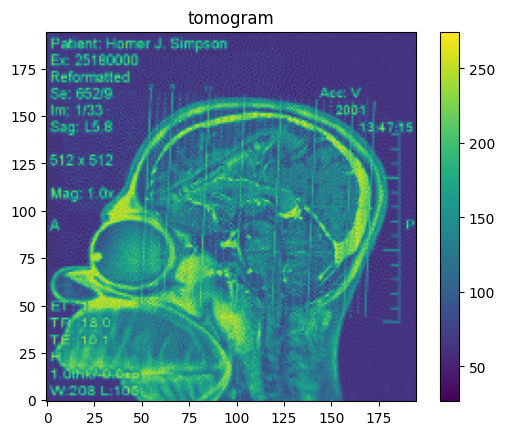

In [7]:
print(f"X.shape={X_195.shape}, y.shape={y_195.shape}")

beta_195 = scipy.sparse.linalg.lsqr(X_195,y_195, atol =1e-08, btol = 1e-08)[0]
print(beta_195)

plt.imshow(beta_195.reshape(-1,M_195), cmap='viridis', origin='lower')
plt.colorbar()
plt.title('tomogram')
plt.show()

Result of self-constructed X_195, with atol=1e-08, btol=1e-08. Took 83 miniutes to run.

According to the tomogram, there's a long cylindrical object(possibly a pencil) in patient's prefontal cortex. That should be the cause of H.S.'s headache. For the treatment, I suggest him to take an operation to remove the object.

## 3. Minimizing the radiation dose

Np=275


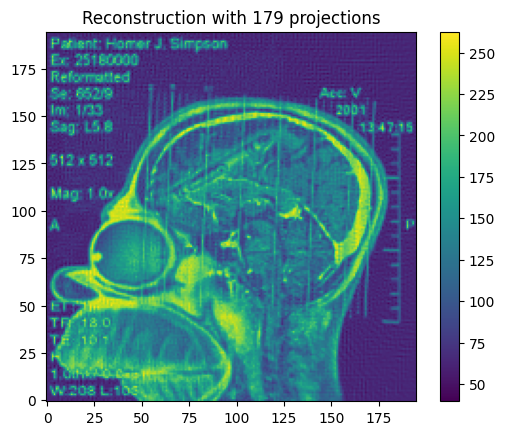

Np=277


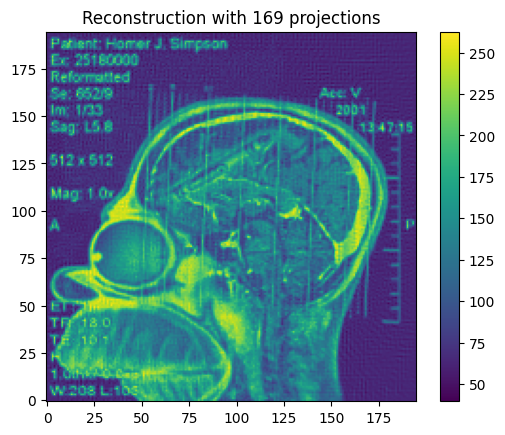

Np=277


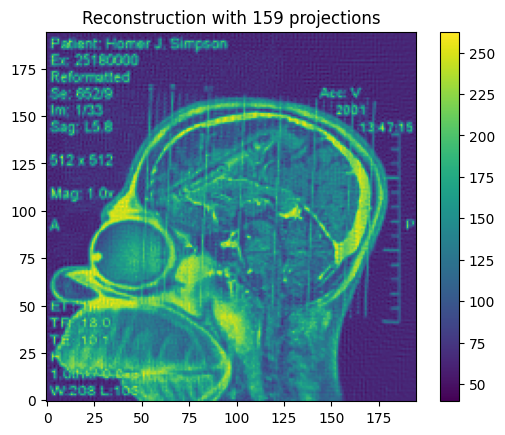

Np=277


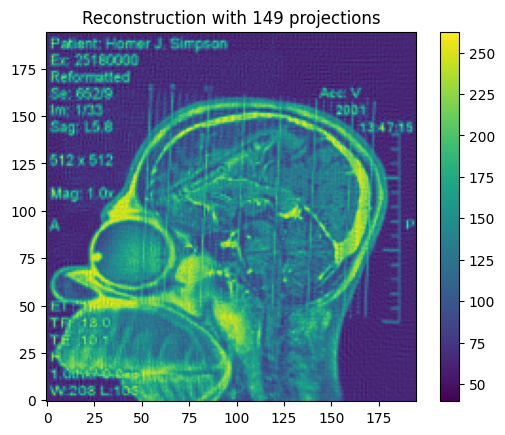

Np=277


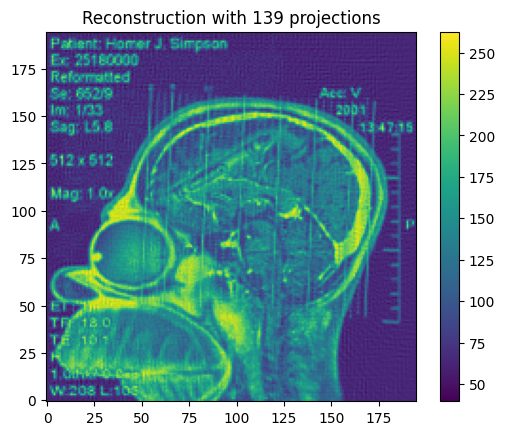

Np=277


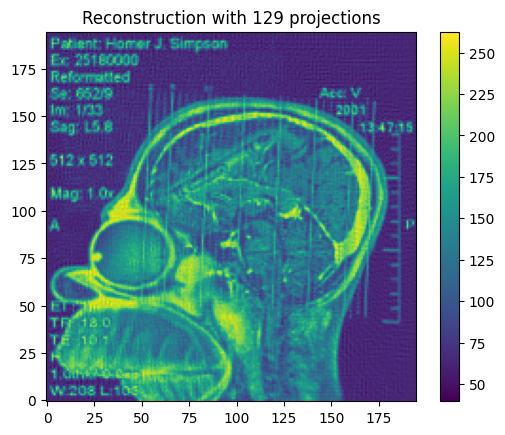

Np=277


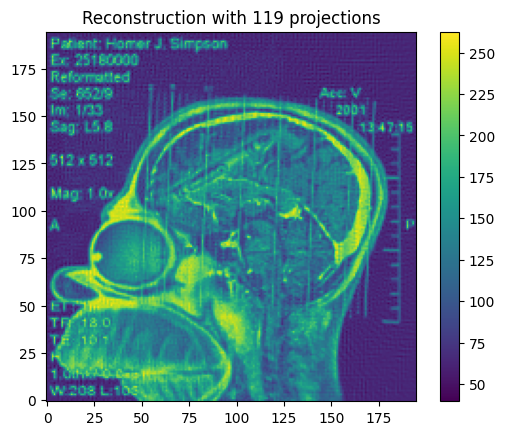

Np=277


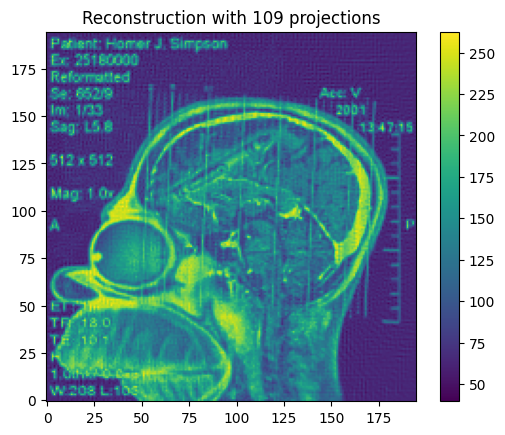

Np=277


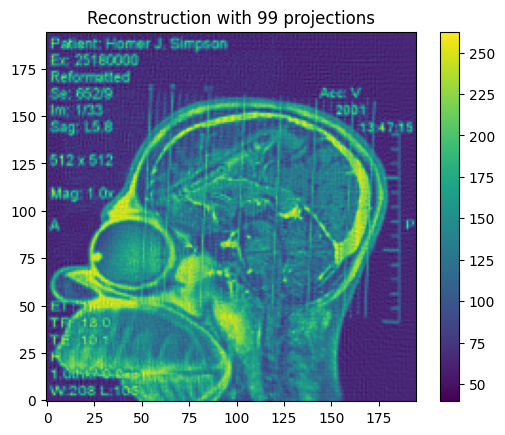

Np=277


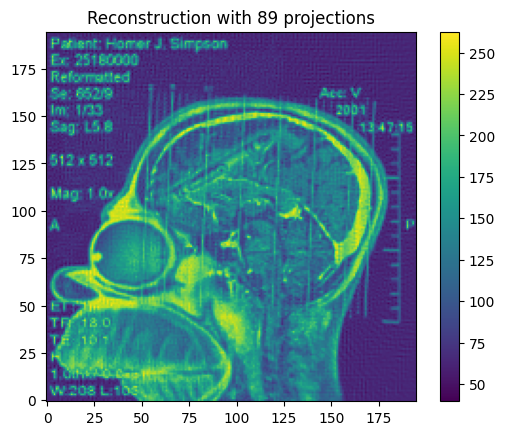

Np=277


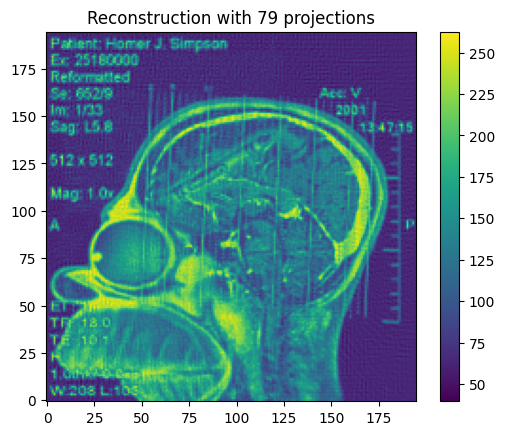

Np=277


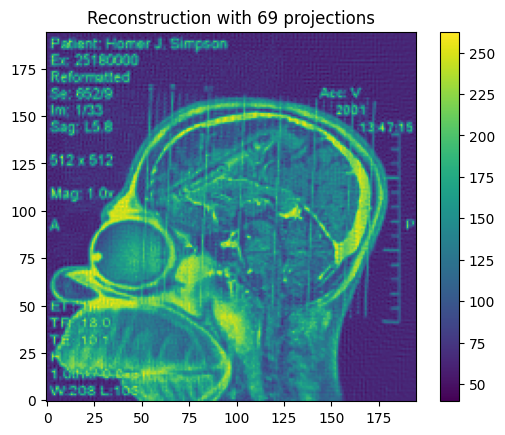

Np=277


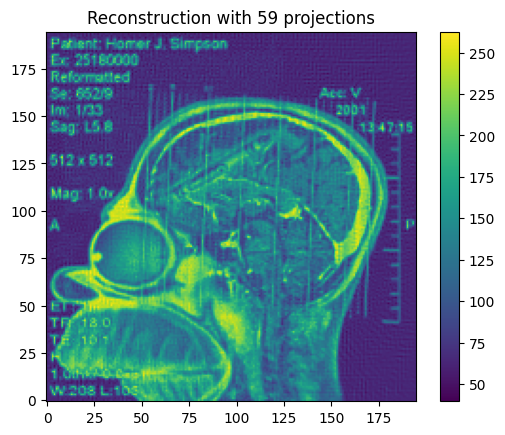

Np=277


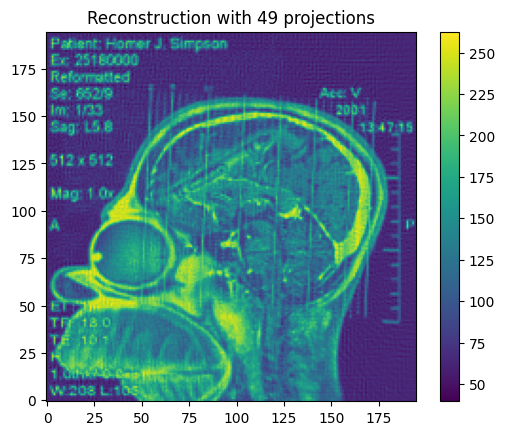

Np=277


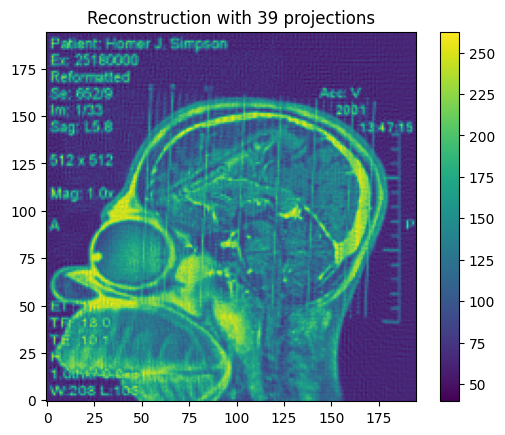

Np=277


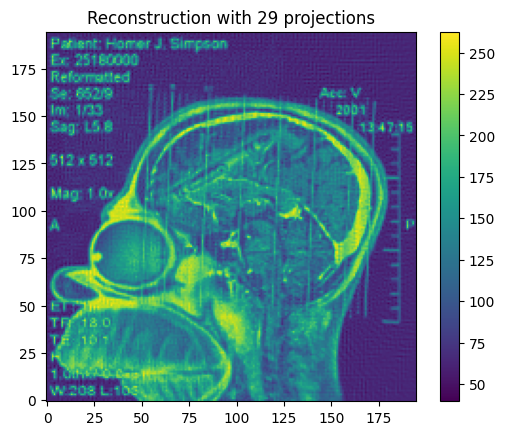

Np=277


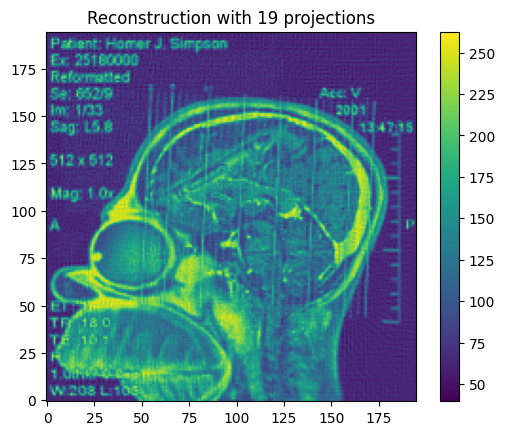

Np=277


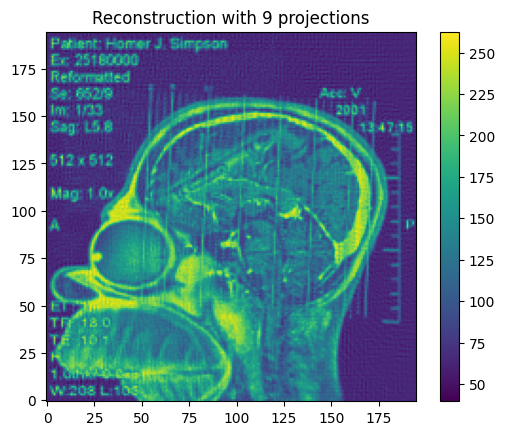

Np=277


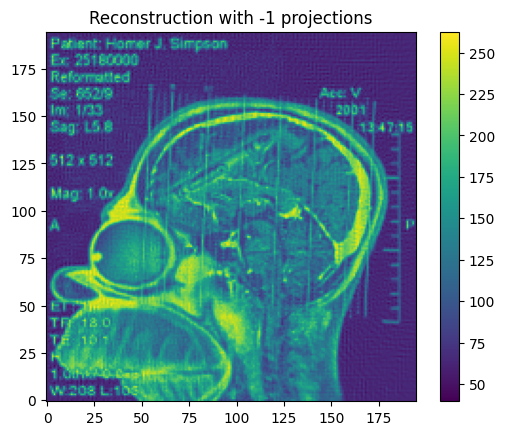

The minimal number of projections for resolution is 9


In [9]:
# Initial parameters

alphas_195 = np.load(os.path.join("alphas_195.npy"))
M = 195  # Size of the tomographic image
N_projections = len(alphas_195)  # Initial number of projection angles

# Reconstruction with the initial number of projections
X_195 = construct_X(M, alphas_195,275)
X_195 = scipy.sparse.csc_matrix(X_195)
y_195 = np.load(os.path.join("y_195.npy"))

# beta = scipy.sparse.linalg.lsqr(X, y, atol=1e-08, btol=1e-08)[0]
beta_195 = scipy.sparse.linalg.lsqr(X_195,y_195, atol =1e-05, btol = 1e-05)[0]

plt.imshow(beta_195.reshape(-1, M), cmap='viridis', origin='lower')
plt.colorbar()
plt.title(f'Reconstruction with {N_projections} projections')
plt.show()

# Gradually reduce the number of projections and visualize the reconstructions
min_resolution = False
while not min_resolution and N_projections >= 0:
    N_projections -= 10  # Reduce the number of projections by 10

    X = construct_X(M, alphas_195)
    X = scipy.sparse.csc_matrix(X)

    beta_195 = scipy.sparse.linalg.lsqr(X_195,y_195, atol =1e-05, btol = 1e-05)[0]

    plt.imshow(beta_195.reshape(-1, M), cmap='viridis', origin='lower')
    plt.colorbar()
    plt.title(f'Reconstruction with {N_projections} projections')
    plt.show()

    # Check if the resolution is still sufficient
    if np.max(beta_195) < 1e-05:
        min_resolution = True

# Print the minimal number of projections that still allows resolution of the cause of the headache
print(f"The minimal number of projections for resolution is {N_projections + 10}")